In [1]:
import pyarrow as pa
import pyarrow_hotfix
import torch
import yaml
import argparse
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import exlib
import math

from datasets import load_dataset
from collections import namedtuple
from exlib.datasets.pretrain import setup_model_config, get_dataset, get_dataset, setup_model_config
from exlib.datasets.dataset_preprocess_raw import create_train_dataloader_raw, create_test_dataloader_raw, create_test_dataloader
from exlib.datasets.informer_models import InformerConfig, InformerForSequenceClassification
from tqdm.auto import tqdm
pa.PyExtensionType.set_auto_load(True)
pyarrow_hotfix.uninstall()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Dataset

In [2]:
# load dataset
dataset = load_dataset("BrachioLab/supernova-timeseries")
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']

In [3]:
train_dataset

Dataset({
    features: ['objid', 'times_wv', 'target', 'label', 'redshift'],
    num_rows: 6274
})

In [4]:
validation_dataset

Dataset({
    features: ['objid', 'times_wv', 'target', 'label', 'redshift'],
    num_rows: 782
})

In [5]:
test_dataset

Dataset({
    features: ['objid', 'times_wv', 'target', 'label', 'redshift'],
    num_rows: 792
})

### Model predictions

In [6]:
# load model
model = InformerForSequenceClassification.from_pretrained("BrachioLab/supernova-classification")
model = model.to(device)
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader(
    config=config,
    dataset=test_dataset,
    batch_size=5,
    compute_loss=True
)

/opt/conda/lib/python3.10/site-packages/huggingface_hub-0.23.2-py3.8.egg/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


num labels: 14
Using Fourier PE
classifier dropout: 0.2
original dataset size: 792
remove nans dataset size: 792


In [7]:
with torch.no_grad():
    y_true = []
    y_pred = []
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        outputs = model(**batch)
        y_true.extend(batch['labels'].cpu().numpy())
        y_pred.extend(torch.argmax(outputs.logits, dim=2).squeeze().cpu().numpy())
# model prediction
print(f"accuracy: {sum([1 for i, j in zip(y_true, y_pred) if i == j]) / len(y_true)}")

  0%|          | 0/159 [00:00<?, ?it/s]

accuracy: 0.7967171717171717


### Dataset Samples

In [8]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [9]:
def plot_data_by_wavelength(times, fluxes, errors, wavelengths, title, bi, j):
    unique_wavelengths = sorted(set(wavelengths))
    color_map = plt.get_cmap('rainbow')
    colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}

    plt.figure(figsize=(4, 4))
    for wavelength in unique_wavelengths:
        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
        plt.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                     fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{int(wavelength)}')
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.title(title, fontsize=10)
    
    plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    #plt.savefig(f'groups_example/plot_org_{bi}_{j}.png', format='png', dpi=300, bbox_inches='tight')
    plt.grid(False)
    plt.close()

In [10]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 12:
            for j in range(len(valid_time_values_batch)):
                plot_data_by_wavelength(valid_time_values_batch[j], valid_flux_values_batch[j], 
                                            valid_flux_error_values_batch[j], valid_wavelength_values_batch[j],
                                            'Flux vs. Time with Error Bars by Wavelength', bi, j)

  0%|          | 0/32 [00:00<?, ?it/s]

In [11]:
### good examples

In [12]:
def plot_data_by_wavelength(times, fluxes, errors, wavelengths, title, bi, j):
    unique_wavelengths = sorted(set(wavelengths))
    color_map = plt.get_cmap('rainbow')
    colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}

    plt.figure(figsize=(4, 4))
    for wavelength in unique_wavelengths:
        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
        plt.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                     fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{int(wavelength)}')
    plt.xlim(59999, 60501)
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.title(title, fontsize=10)
    
    plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    plt.savefig(f'groups_example/plot_org_{bi}_{j}.png', format='png', dpi=300, bbox_inches='tight')
    plt.grid(False)
    plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

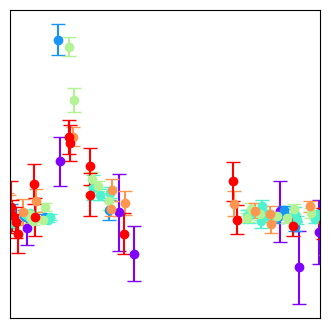

In [13]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 12:
            for j in range(len(valid_time_values_batch)):
                if j == 7:
                    times = valid_time_values_batch[j]
                    fluxes = valid_flux_values_batch[j]
                    errors = valid_flux_error_values_batch[j]
                    wavelengths = valid_wavelength_values_batch[j]
                    unique_wavelengths = sorted(set(wavelengths))
                    color_map = plt.get_cmap('rainbow')
                    colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
                    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}
                
                    plt.figure(figsize=(4, 4))
                    for wavelength in unique_wavelengths:
                        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
                        plt.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                                     fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{int(wavelength)}')
                    plt.xlim(59999, 60501)
                    #plt.xlabel('Time')
                    #plt.ylabel('Flux')
                    #plt.title(title, fontsize=10)
                    plt.xticks([]),plt.yticks([])
                    #plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
                    plt.savefig(f'groups_example/plot_org_ver_{bi}_{j}.png', format='png', dpi=300, bbox_inches='tight')
                    plt.grid(False)
                    plt.show()

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_selected_wavelengths(times, fluxes, errors, wavelengths, bi, j):
    # Define the intervals and corresponding wavelengths and colors
    unique_wavelengths = sorted(set(wavelengths))
    color_map_r = plt.get_cmap('rainbow')
    colors = color_map_r(np.linspace(0, 1, len(unique_wavelengths)))
    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}
    
    intervals = [(59999, 60075, 9710.2802734375, wavelength_to_color[9710.2802734375]),
                 (60075, 60200, 7545.97998046875, wavelength_to_color[7545.97998046875]),
                 (60345, 60501, 6223.240234375, wavelength_to_color[6223.240234375])]

    intervals_h = [(59999, 60075, 'red'),
                 (60075, 60200, 'green'),
                 (60350, 60501, wavelength_to_color[4826.85009765625])]
    # Create a dictionary for quick access to colors based on conditions
    color_map = {'default': 'grey'}
    for start, end, wave, color in intervals:
        color_map[(start, end, wave)] = color

    plt.figure(figsize=(4, 4))
    


    
    for wavelength in unique_wavelengths:
        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
        times_filtered = [times[i] for i in indices]
        fluxes_filtered = [fluxes[i] for i in indices]
        errors_filtered = [errors[i] for i in indices]
        
        # Determine color based on conditions
        colors = []
        for time in times_filtered:
            color = color_map['default']
            for start, end, wave, col in intervals:
                if start <= time <= end and wavelength == wave:
                    color = col
                    break
            colors.append(color)
        
        # Plot each point individually to apply the specific color
        for t, f, e, c in zip(times_filtered, fluxes_filtered, errors_filtered, colors):
            plt.errorbar(t, f, yerr=e, fmt='o', color=c, capsize=5)

    for start, end, color in intervals_h:
        plt.axvspan(start, end, color=color, alpha=0.3)  # Adjust alpha for transparency as needed
    plt.xlim(59999, 60501)
    #plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    plt.grid(False)
    plt.xticks([]),plt.yticks([])
    plt.savefig(f'groups_example/plot_selected_{bi}_{j}.png', format='png', dpi=300, bbox_inches='tight')
    plt.show()

  0%|          | 0/32 [00:00<?, ?it/s]

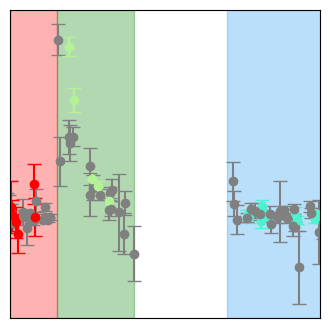

In [15]:
# dataset sample
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 12:
            for j in range(len(valid_time_values_batch)):
                if j == 7:
                    times = valid_time_values_batch[j]
                    fluxes = valid_flux_values_batch[j]
                    errors = valid_flux_error_values_batch[j]
                    wavelengths = valid_wavelength_values_batch[j]
                    unique_wavelengths = sorted(set(wavelengths))
                    plot_selected_wavelengths(times, fluxes, errors, wavelengths, bi, j)

  0%|          | 0/32 [00:00<?, ?it/s]

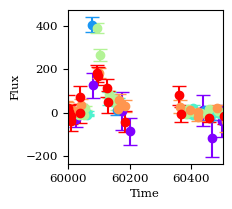

In [16]:
# dataset sample
csfont = {'fontname':'Serif'}
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 12:
            for j in range(len(valid_time_values_batch)):
                if j == 7:
                    times = valid_time_values_batch[j]
                    fluxes = valid_flux_values_batch[j]
                    errors = valid_flux_error_values_batch[j]
                    wavelengths = valid_wavelength_values_batch[j]
                    unique_wavelengths = sorted(set(wavelengths))
                    color_map = plt.get_cmap('rainbow')
                    colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
                    wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}
                
                    plt.figure(figsize=(2, 2))
                    for wavelength in unique_wavelengths:
                        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
                        plt.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                                     fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{int(wavelength)}')
                    plt.xlim(59999, 60501)
                    plt.xticks(fontsize=8.5,**csfont)
                    plt.xlabel('Time', fontsize=8.5,**csfont)
                    plt.yticks(fontsize=8.5,**csfont)
                    plt.ylabel('Flux', fontsize=8.5,**csfont)
                    #plt.title(title, fontsize=10)
                    
                    #plt.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
                    plt.savefig(f'groups_example/plot_org_{bi}_{j}.png', format='png', dpi=300, bbox_inches='tight')
                    plt.grid(False)
                    plt.show()

### Alignment score without ground truth

In [17]:
config = InformerConfig.from_pretrained("BrachioLab/supernova-classification")
test_dataloader = create_test_dataloader_raw(
    config=config,
    dataset=test_dataset,
    batch_size=25,
    compute_loss=True
)

original dataset size: 792
remove nans dataset size: 792


In [18]:
# baseline
chunk_size = 30
def baseline(valid_length):
    num_groups = valid_length // chunk_size
    if valid_length % chunk_size != 0:
        num_groups += 1
    pred_groups = []
    for group_idx in range(num_groups):
        start_index = group_idx * chunk_size
        end_index = min((group_idx + 1) * chunk_size, valid_length)
        group_list = [1 if start_index <= i < end_index else 0 for i in range(valid_length)]
        pred_groups.append(group_list)
    return pred_groups

In [19]:
def perform_linear_regression(x, y, min_len=3):
    if not x or len(x) < min_len:
        return (1000, 1000)
    x = np.array(x)
    y = np.array(y)
    slope, intercept = np.polyfit(x, y, 1)
    return (slope, intercept)

In [20]:
def threshold_f(eps, error, time):
    if not error or not time:
        return 0
    time_range = max(time) - min(time)
    if time_range == 0:
        return 0
    thres = eps * (sum(error)/len(error)) / (time_range)
    return thres

In [21]:
def plot_flux_time_with_error_bars_group(times, wavelengths, fluxes, errors, pred_groups, unique_wavelengths, wavelength_to_color, bi, j, k, max_lc):
    plt.figure(figsize=(4, 4))
    ax = plt.gca()

    title = 'Flux vs. Time with Error Bars by Wavelength (Expert Alignment: {:.2f})'.format(max_lc)
    #ax.set_title(title, fontsize=10)
    
    for wavelength in unique_wavelengths:
        indices = [i for i, w in enumerate(wavelengths) if w == wavelength]
        ax.errorbar([times[i] for i in indices], [fluxes[i] for i in indices], yerr=[errors[i] for i in indices],
                    fmt='o', color=wavelength_to_color[wavelength], capsize=5, label=f'{int(wavelength)}')
    
    # Highlight expert alignment groups
    for i in range(len(pred_groups[j][k])):
        if pred_groups[j][k][i] == 1:
            if i == 0 or pred_groups[j][k][i-1] == 0:  # Start of a new span
                start_time = times[i]
            if i == len(pred_groups[j][k]) - 1 or pred_groups[j][k][i+1] == 0:  # End of a span
                end_time = times[i]
                ax.axvspan(start_time, end_time, color='gray', alpha=0.3)  # Adding the vertical span
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Flux')
    ax.legend(title="Wavelengths", loc='upper right', fontsize='small', title_fontsize='small')
    ax.grid(False)  # Disable grid explicitly if needed
    plt.savefig(f'groups_example/plot_{bi}_{j}_{k}.png', format='png', dpi=300, bbox_inches='tight')
    plt.close()

In [22]:
# alignment score - without ground truth
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
            
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        # predicted group
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)
            
            pred_groups = baseline(valid_length)
            pred_groups_batch.append(pred_groups)
            # pred_groups_batch: batch_size * pred_group_num * valid_length

        for j in range(len(valid_time_values_batch)): # j: batch size
            times = valid_time_values_batch[j]
            fluxes = valid_flux_values_batch[j]
            errors = valid_flux_error_values_batch[j]
            wavelengths = valid_wavelength_values_batch[j]
            unique_wavelengths = sorted(set(wavelengths))
            num_unique_wavelengths = len(unique_wavelengths)
            time_wv = {wavelength: [] for wavelength in unique_wavelengths}
            flux_wv = {wavelength: [] for wavelength in unique_wavelengths}
            error_wv = {wavelength: [] for wavelength in unique_wavelengths}
            
            for time, flux, error, wavelength in zip(times, fluxes, errors, wavelengths):
                time_wv[wavelength].append(time)
                flux_wv[wavelength].append(flux)
                error_wv[wavelength].append(error)
            unique_wavelengths = sorted(set(wavelengths))
            color_map = plt.get_cmap('rainbow')
            colors = color_map(np.linspace(0, 1, len(unique_wavelengths)))
            wavelength_to_color = {w: c for w, c in zip(unique_wavelengths, colors)}

            eps = 1
            min_len = 3
            window_size = 50
            step_size = int(window_size / 2)
            for k in range(len(pred_groups_batch[j])): # k: number of group
                group_time = [times[i] for i, value in enumerate(pred_groups_batch[j][k]) if value == 1]
                group_slope = []
                group_intercept = []
                group_threshold = []
                group_lc = []
                group_p = []
                group_f = []
                #chunk_time = [[time, time + window_size] for time in crop_time_wv]
                chunk_time = []
                current_start = group_time[0]
                while current_start + window_size < group_time[-1]:
                    chunk_time.append([current_start, current_start + window_size])
                    current_start += step_size
                chunk_time.append([current_start, current_start + window_size])
                for m in range(len(unique_wavelengths)):
                    chunk_f = 0
                    chunk_p = 0
                    crop_time_wv = [time for time in time_wv[unique_wavelengths[m]] if time in group_time]
                    
                    crop_flux_wv = [flux_wv[unique_wavelengths[m]][i] for i, time in enumerate(time_wv[unique_wavelengths[m]]) if time in group_time]
                    crop_error_wv = [error_wv[unique_wavelengths[m]][i] for i, time in enumerate(time_wv[unique_wavelengths[m]]) if time in group_time]
                    slope, intercept = perform_linear_regression(crop_time_wv, crop_flux_wv)
                    group_slope.append(slope)
                    group_intercept.append(intercept)
                    threshold = threshold_f(eps, crop_error_wv, crop_time_wv)
                    group_threshold.append(threshold)
                    p_in = 0
                    pos_f = 0
                    if len(crop_time_wv) >= min_len:
                        for time, flux, error in zip(crop_time_wv, crop_flux_wv, crop_error_wv):
                            predicted_flux = group_slope[m] * time + group_intercept[m]
                            lower_bound = flux - (eps*error)
                            upper_bound = flux + (eps*error)
                            if lower_bound <= predicted_flux <= upper_bound:
                                pos_f += 1
                    if len(crop_time_wv) == 0:
                        perc = 0
                    else:
                        perc = pos_f / len(crop_time_wv)
                    group_f.append(perc)
                    for n in range(len(chunk_time)):
                        chunk_time_wv = [time for time in crop_time_wv if chunk_time[n][0] <= time <= chunk_time[n][1]]
                        indices = [i for i, time in enumerate(crop_time_wv) if time in chunk_time_wv]
                        chunk_flux_wv = [crop_flux_wv[i] for i in indices]
                        chunk_error_wv = [crop_error_wv[i] for i in indices]
                        if chunk_time_wv:
                            p_in += 1
                    group_p.append(p_in / len(chunk_time))
                group_lc = []
                for p, f in zip(group_p, group_f):
                    group_lc.append(p * f)
                if all(slope <= threshold for slope, threshold in zip(group_slope, group_threshold)):
                    max_lc = max(group_lc)
                else:
                    max_lc = max(lc for slope, lc, threshold in zip(group_slope, group_lc, group_threshold) if slope > threshold)
                alignment_scores_all.append(max_lc)
                # save plots
                if bi == 0:
                    if k == 8:
                        plot_flux_time_with_error_bars_group(times, wavelengths, fluxes, errors, pred_groups_batch, unique_wavelengths, wavelength_to_color, bi, j, k, max_lc)
                    
print("score:", sum(alignment_scores_all)/len(alignment_scores_all), len(alignment_scores_all))

  0%|          | 0/32 [00:00<?, ?it/s]

score: 0.46856252108295665 4899


### Alignment score with ground truth

In [368]:
# ground truth
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        #print(time_values)
        wavelength_values = x_column[:, :, 1].tolist()
        flux_values = x_column[:, :, 2].tolist()
        flux_error_values = x_column[:, :, 3].tolist()
        
        valid_time_values_batch = []
        valid_wavelength_values_batch = []
        valid_flux_values_batch = []
        valid_flux_error_values_batch = []
        zeros_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            valid_wavelength_values_batch.append(wavelength_values[idx][:valid_length])
            valid_flux_values_batch.append(flux_values[idx][:valid_length])
            valid_flux_error_values_batch.append(flux_error_values[idx][:valid_length])
            valid_length_batch.append(valid_length)

        if bi == 0:
            int_time_values_batch = []
            window_size = 15
            window_time_values_batch = []
            window_flux_values_batch = []
            for j in range(len(valid_time_values_batch)):
                unique_wavelengths = sorted(set(valid_wavelength_values_batch[j]))
                #print(unique_wavelengths)
                start = math.floor(valid_time_values_batch[j][0])
                end = math.ceil(valid_time_values_batch[j][-1])
                int_time_values_batch.append(list(range(start, end + 1)))
                window_time_values_batch.append([[int_time_values_batch_j[i], int_time_values_batch_j[i + window_size - 1]] for i in range(len(int_time_values_batch_j) - window_size + 1)])
                #print(len(window_time_values_batch), len(window_time_values_batch[j]), window_time_values_batch[j][0])
                
                batch_windows = []
                for k in range(len(window_time_values_batch[j])):
                    window_wavelengths = [0] * len(unique_wavelengths)
                    batch_windows.append(window_wavelengths)
                window_flux_values_batch.append(batch_windows)
                #print(len(window_flux_values_batch), len(window_flux_values_batch[j]), len(window_flux_values_batch[j][0]))

                for k in range(len(unique_wavelengths)):
                    target_wavelength = unique_wavelengths[k]
                    indices_with_target_wavelength = [i for i, wavelength in enumerate(valid_wavelength_values_batch[j]) if wavelength == target_wavelength]
                    #print("Indices with wavelength", target_wavelength, ":", indices_with_target_wavelength)
            #print(len(window_time_values_batch), len(window_time_values_batch[j]), window_time_values_batch[j][0])
            #print(len(window_flux_values_batch), len(window_flux_values_batch[j]), len(window_flux_values_batch[j][0]))
            #print(window_flux_values_batch[j])
            #break

  0%|          | 0/198 [00:00<?, ?it/s]

In [49]:
# alignment score - with ground truth
def process_group_pair(pred_group, true_group, device):
    pred_groups = torch.tensor(pred_group, dtype=torch.float32).to(device)
    true_groups = torch.tensor(true_group, dtype=torch.float32).to(device)
    pred_groups_bool = pred_groups.to(torch.bool)
    true_groups_bool = true_groups.to(torch.bool)
    intersections = (pred_groups_bool.unsqueeze(1) & true_groups_bool.unsqueeze(0)).float().sum(dim=2)
    unions = (pred_groups_bool.unsqueeze(1) | true_groups_bool.unsqueeze(0)).float().sum(dim=2)
    ious = intersections / unions
    ious = torch.nan_to_num(ious, nan=0.0)
    max_iou, _ = torch.max(ious, dim=1)
    avg_list = []
    for col in range(pred_groups.size(1)):
        mask = pred_groups[:, col] == 1
        if torch.any(mask):
            avg_iou = max_iou[mask].mean().item()
        else:
            avg_iou = 0
        avg_list.append(avg_iou)
    return avg_list

def calculate_alignment_scores(pred_groups_batch, true_groups_batch, device):
    alignment_scores = []
    for i in range(len(pred_groups_batch)):
        avg_list = process_group_pair(pred_groups_batch[i], true_groups_batch[i], device)
        alignment_score = sum(avg_list) / len(avg_list) if avg_list else 0
        alignment_scores.append(alignment_score)
    return alignment_scores

In [258]:
with torch.no_grad():
    alignment_scores_all = []
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        # prediction
        batch = {k: v.to(device) for k, v in batch.items() if k != "objid"}
        
        times_wv_column = batch['past_time_features'].to('cpu')
        target_column = batch['past_values'].to('cpu')
        x_column = np.concatenate((times_wv_column, target_column), axis=2) # time, wavelength, flux, flux_error
        time_values = x_column[:, :, 0].tolist() # time_values is from 0 to 1, and if it is less than 300 random values
        
        # predicted group
        valid_time_values_batch = []
        valid_length_batch = []
        pred_groups_batch = []
        for idx, time_list in enumerate(time_values):
            valid_length = next((j for j in range(1, len(time_list)) if time_list[j] <= time_list[j-1]), len(time_list))
            valid_time_values_batch.append(time_list[:valid_length])
            
            pred_groups = baseline(valid_length)
            pred_groups_batch.append(pred_groups)
            # pred_groups_batch: batch_size * pred_group_num * valid_length

        # ground truth group - need to update
        true_groups_batch = pred_groups_batch
        #true_groups_batch = [[[0.0 for _ in sub_group] for sub_group in group] for group in pred_groups_batch]

        # alignment score
        alignment_scores = calculate_alignment_scores(pred_groups_batch, true_groups_batch, device)
        alignment_scores_all.extend(alignment_scores)
# all alignment score
print(f"average alignment score: {sum(alignment_scores_all) / len(alignment_scores_all)}")

  0%|          | 0/159 [00:00<?, ?it/s]

average alignment score: 1.0
